In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots

In [71]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_step.jl")

In [215]:
     
    true_var_coeff = [.6 .3;  .4 .7]
    true_trend_covariance = [.015/200 0 
                             0 .01/400]

    true_cycle_covariance = [.02^2 .0002
                            .0002 .015^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [.02^2 .0002
                                     .0002 .015^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    true_states, observations= sample(true_model, 660)

    n_presample = 60

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
 
 

600×4 Matrix{Float64}:
 -1.07508  -0.761129  -0.198862    -0.256549
 -1.07791  -0.758182  -0.174449    -0.248242
 -1.07907  -0.765217  -0.168822    -0.249367
 -1.08665  -0.765251  -0.187014    -0.226813
 -1.08803  -0.757437  -0.141968    -0.219386
 -1.091    -0.760795  -0.171044    -0.227802
 -1.10902  -0.756385  -0.167829    -0.226682
 -1.1068   -0.75394   -0.175109    -0.214207
 -1.11001  -0.75285   -0.131125    -0.182577
 -1.11294  -0.745187  -0.122915    -0.202699
  ⋮                                
 -1.1881   -0.900948   0.0714151    0.0769582
 -1.18879  -0.903855   0.0634179    0.0768629
 -1.20242  -0.895195   0.0580051    0.0607318
 -1.19721  -0.895315   0.067233     0.0745318
 -1.18262  -0.895788   0.0283772    0.0676282
 -1.17457  -0.897557   0.0326696    0.0531814
 -1.15972  -0.908272   0.00950326   0.0357464
 -1.15308  -0.912241   0.0159361    0.0217869
 -1.15172  -0.912332   0.0149761    0.0129182

In [216]:
mean(presample_data, dims=1)

1×2 Matrix{Float64}:
 -1.20703  -1.97579

In [217]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 -1.24131  -2.06837

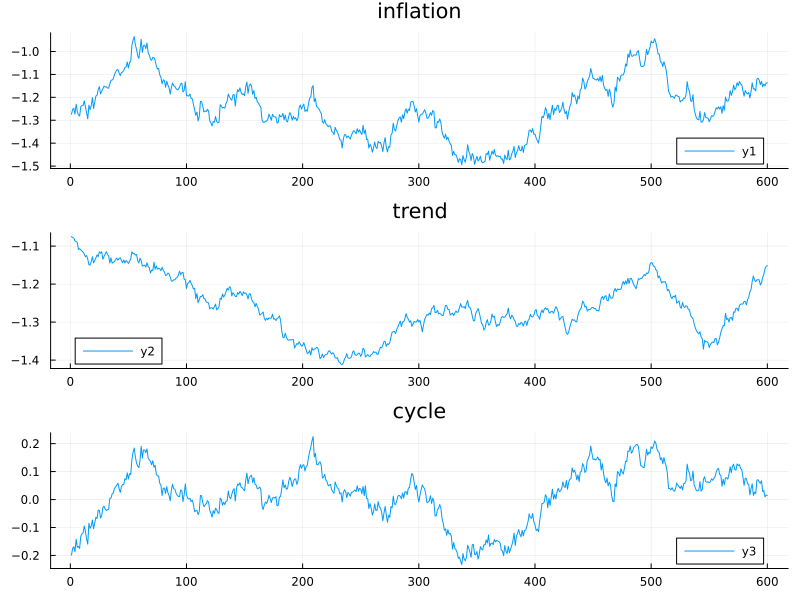

In [218]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

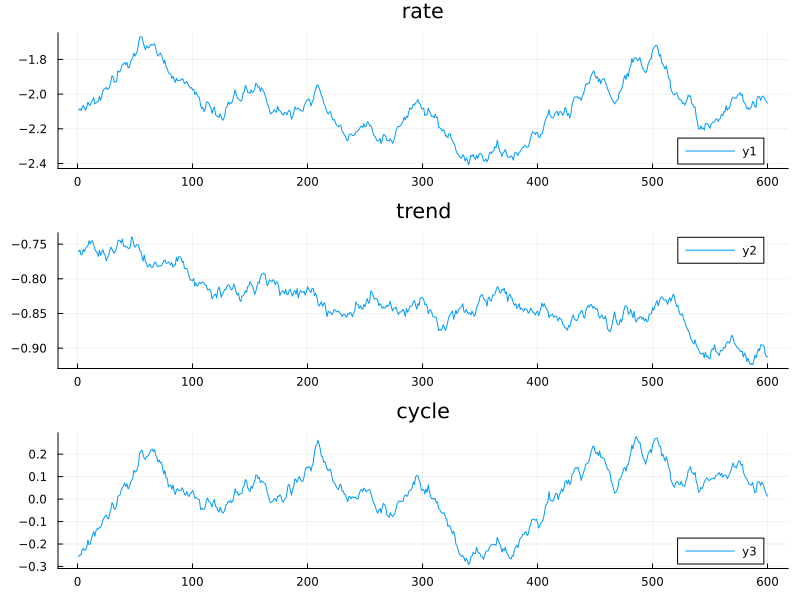

In [219]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [220]:
priors = (
        initial_trend_mean = mean(presample_data, dims=1)[1,:],
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([1/200, 1/400].^2) * (priors.trend_covariance_df + 2 +1),
        )

(initial_trend_mean = [-1.207029543644922, -1.9757926638606953], trend_covariance_df = 100, trend_covariance_mean = [0.002575 0.0; 0.0 0.00064375])

In [221]:
model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        priors.initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)

StateSpaceModel([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.6 0.3; 0.0 0.0 0.4 0.7], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [1.0 0.0 1.0 0.0; 1.0 1.0 0.0 1.0], [7.5e-5 0.0 0.0 0.0; 0.0 2.5e-5 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225], [2.220446049250313e-16 0.0; 0.0 2.220446049250313e-16], [-1.207029543644922, -1.9757926638606953, 0.0, 0.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225])

In [222]:
  state_filtered, covariance_filtred, state_predicted, covariance_predicted, ll = kalman_filter(model, data) 
   

   # Run Carter-Kohn sampler
    println("Running Carter-Kohn sampler...")
    state_smoothed_samples = carter_kohn_sampler(model, data, n_samples=10_000)
   
    # Compute posterior statistics
    state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  
 

Running Carter-Kohn sampler...


([-1.2693517260193097 -0.8223265696776237 -0.004592360600835138 -0.0010812483554674763; -1.2667557244156886 -0.8223930294886915 0.014399836500680545 0.004817886529802043; … ; -1.1688830389943559 -0.9044731976257144 0.03173600002916908 0.029818970910988833; -1.1707553673399593 -0.9065592351069799 0.03401018522322054 0.026179203504484314], [-1.3075835769926287 -0.8407002483525398 -0.0430813784839176 -0.04558650710363621; -1.3067126889408565 -0.8398719445123403 -0.025742586506357915 -0.04297111231204672; … ; -1.4907645391275186 -1.0120058278915482 -0.2869887497570939 -0.3928552353714416; -1.4949216804837002 -1.014424753501417 -0.28439825385695433 -0.39731867672659815], [-1.230878180117985 -0.8040725067577668 0.03364158977937658 0.042459776173269285; -1.2266066887222093 -0.8045121556203989 0.054365266785082945 0.052319917891074395; … ; -0.8501508774730586 -0.7984271657120249 0.3536003216921434 0.4581748589589106; -0.8523469391606 -0.8011493092602318 0.358176528876519 0.4564809521277421])

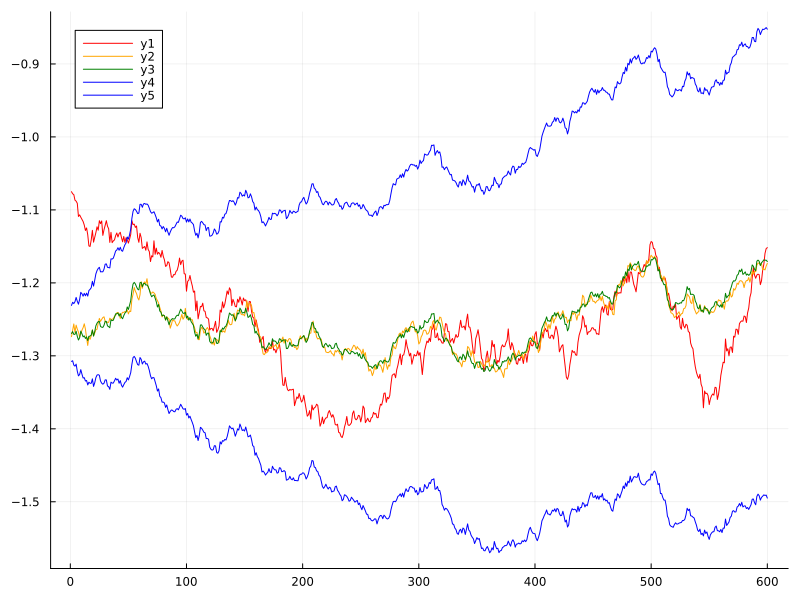

In [233]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

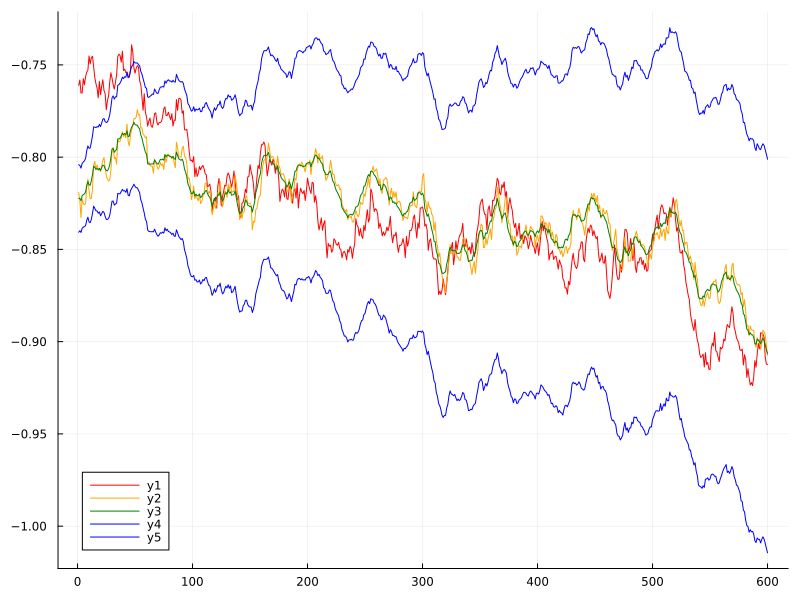

In [234]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

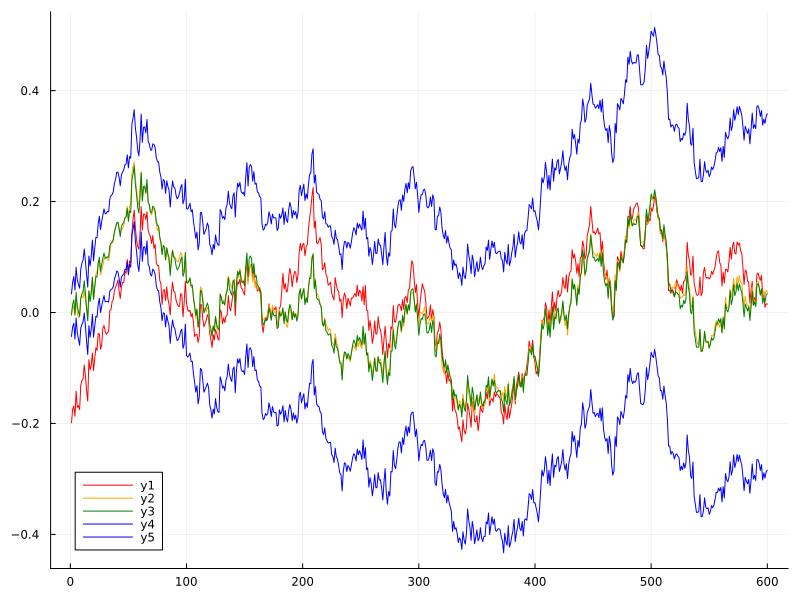

In [235]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

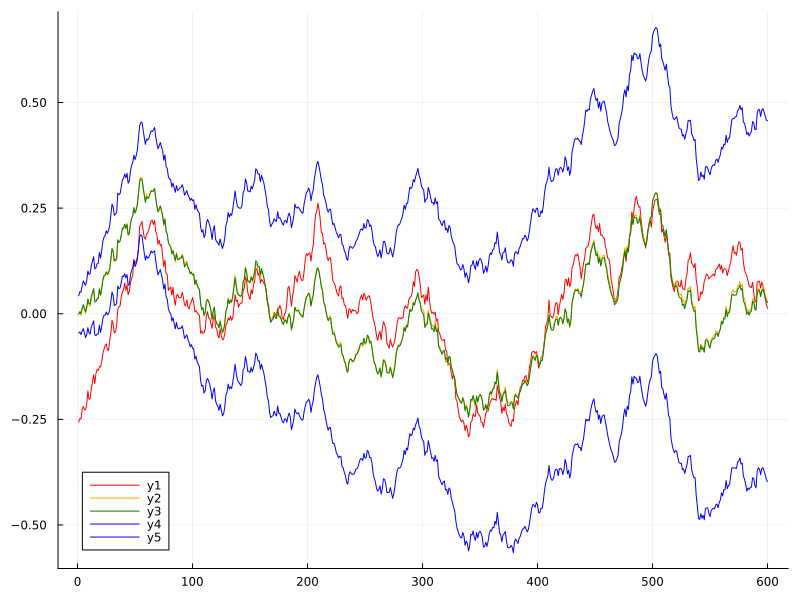

In [236]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

In [237]:
var_priors = minnesota_priors(data, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])
reshape(var_priors, 3, 2)

3×2 Matrix{Normal}:
 Normal{Float64}(μ=0.0, σ=0.2)        Normal{Float64}(μ=0.0, σ=0.256687)
 Normal{Float64}(μ=0.0, σ=0.155832)   Normal{Float64}(μ=0.0, σ=0.2)
 Normal{Float64}(μ=0.0, σ=0.0253804)  Normal{Float64}(μ=0.0, σ=0.032574)

In [252]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 0.05014933982701087
 0.0154828414900048

2-element Vector{Float64}:
 0.22394048277837322
 0.12443006666398922

In [239]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 699.0
Ψ: [0.05272433982701087 0.00016877303551182204; 0.00016877303551182204 0.0161265914900048]
)


In [249]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist)).^.5
end


display(mean(cov_posterior, dims=1))


1×2 Matrix{Float64}:
 0.00869983  0.00481006

In [242]:
stds = zeros(10_000, 2)


for n in 1:10_000
    stds = rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean))
end

mean(stds, dims=1) 


1×2 Matrix{Float64}:
 1.12439e-5  3.33483e-6